## Quick Demo - All Three Models

Run the cells below for a quick demonstration of all three NLP capabilities.

### 🍎 Why MLX?
**MLX** is an array framework designed specifically for machine learning on Apple Silicon (M1/M2/M3 chips). 

**Key Architectural Advantages:**
1.  **Unified Memory Model**: Unlike CUDA (NVIDIA) where you must copy data between CPU RAM and GPU VRAM, MLX uses "Unified Memory". Arrays live in shared memory, allowing the CPU and GPU to work on the same data without expensive copying.
2.  **Lazy Evaluation**: Computations are only performed when the results are actually needed. This allows MLX to optimize the computation graph automatically.
3.  **Dynamic Graph Construction**: Similar to PyTorch, graphs are built on-the-fly, making debugging easy.

### 🖥️ Hardware Acceleration: GPU vs NPU
Apple Silicon chips contain both a **GPU** (Graphics Processing Unit) and an **NPU** (Neural Engine).
*   **GPU**: Excellent for general-purpose parallel processing (like training LSTMs and Transformers). MLX primarily targets the GPU.
*   **NPU**: Specialized for specific matrix operations (inference). While MLX can utilize the NPU for certain operations, general training loops typically run on the GPU for flexibility and speed.

In this notebook, we use a consolidated utility library `mlx_nlp_utils` to hide the complexity and focus on the results. We will verify that we are using the **GPU** for acceleration.

In [1]:
# Setup and imports
import sys
import numpy as np
import importlib

# MLX for deep learning on Apple Silicon
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Import our consolidated utilities
import mlx_nlp_utils
importlib.reload(mlx_nlp_utils)  # Force reload to get latest changes
from mlx_nlp_utils import (
    IntentLSTM, SentimentLSTM, TextLSTM,
    load_sample_intent_data, load_sample_sentiment_data, load_sample_corpus,
    train_model, predict_intent, predict_sentiment, generate_text,
    print_device_info
)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print("📦 MLX NLP Overview is ready!")
print(f"🖥️  MLX version: {mx.__version__}")
print(f"🐍 Python version: {sys.version.split()[0]}")

# Check hardware acceleration
print_device_info()

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# Demo 1: Intent Classification
print("=" * 60)
print("DEMO 1: Intent Classification")
print("=" * 60)

# Load sample data
texts, labels, vocab, intent2idx = load_sample_intent_data()
print(f"\n📊 Loaded {len(texts)} examples with {len(intent2idx)} intents")

# Prepare data
max_len = max(len(t.split()) for t in texts)
X = []
for text in texts:
    tokens = [vocab.get(word.lower(), vocab["<UNK>"]) for word in text.split()]
    tokens += [vocab["<PAD>"]] * (max_len - len(tokens))
    X.append(tokens)

X = mx.array(X, dtype=mx.int32)
# X represents the input features (sequences of word indices)
# y represents the target labels (intent indices)
y = mx.array([intent2idx[label] for label in labels], dtype=mx.int32)

# Create and train model
model = IntentLSTM(len(vocab), 32, 64, len(intent2idx))
print("\nTraining model...")
model, history = train_model(model, X, y, epochs=20, learning_rate=0.01)

# Test predictions
print("\n" + "-" * 60)
print("Testing predictions:")
test_inputs = ["hello there", "what time is it", "turn on the lights"]
intent_names = list(intent2idx.keys())

for text in test_inputs:
    intent, conf = predict_intent(model, text, vocab, intent_names, max_len)
    print(f"  '{text}' → {intent} ({conf:.1%})")

print("\n✅ Intent classification demo complete!")

DEMO 1: Intent Classification
Loading intent data from ../data/intent_samples/data.json

📊 Loaded 160 examples with 3 intents

Training model...
Epoch  10/20 - Loss: 0.3361 - Accuracy: 0.8688
Epoch  20/20 - Loss: 0.3348 - Accuracy: 0.8688

------------------------------------------------------------
Testing predictions:
  'hello there' → command (73.8%)
  'what time is it' → question (100.0%)
  'turn on the lights' → command (73.8%)

✅ Intent classification demo complete!


In [ ]:
# Demo 2: Sentiment Analysis
print("\n" + "=" * 60)
print("DEMO 2: Sentiment Analysis")
print("=" * 60)

# Load sample data
texts, labels, vocab, sentiment2idx = load_sample_sentiment_data()
print(f"\n📊 Loaded {len(texts)} examples with {len(sentiment2idx)} sentiments")

# Prepare data
max_len = max(len(t.split()) for t in texts)
X = []
for text in texts:
    tokens = [vocab.get(word.lower(), vocab["<UNK>"]) for word in text.split()]
    tokens += [vocab["<PAD>"]] * (max_len - len(tokens))
    X.append(tokens)

X = mx.array(X, dtype=mx.int32)
y = mx.array([sentiment2idx[label] for label in labels], dtype=mx.int32)

# Create and train model
model = SentimentLSTM(len(vocab), 64, 128, len(sentiment2idx))
print("\nTraining model...")
model, history = train_model(model, X, y, epochs=20, learning_rate=0.01)

# Test predictions
print("\n" + "-" * 60)
print("Testing predictions:")
test_reviews = [
    "I absolutely love this!",
    "Terrible waste of money",
    "It's okay, nothing special"
]
sentiment_names = list(sentiment2idx.keys())

for text in test_reviews:
    sentiment, probs = predict_sentiment(model, text, vocab, sentiment_names, max_len)
    print(f"  '{text}' → {sentiment}")

print("\n✅ Sentiment analysis demo complete!")


DEMO 2: Sentiment Analysis
Loading sentiment data from ../data/sentiment_samples/data.json

📊 Loaded 150 examples with 3 sentiments

Training model...
Epoch  10/20 - Loss: 0.5123 - Accuracy: 0.9333
Epoch  20/20 - Loss: 0.0014 - Accuracy: 1.0000

------------------------------------------------------------
Testing predictions:
  'I absolutely love this!' → positive
  'Terrible waste of money' → negative
  'It's okay, nothing special' → positive

✅ Sentiment analysis demo complete!
Epoch  10/20 - Loss: 0.5123 - Accuracy: 0.9333
Epoch  20/20 - Loss: 0.0014 - Accuracy: 1.0000

------------------------------------------------------------
Testing predictions:
  'I absolutely love this!' → positive
  'Terrible waste of money' → negative
  'It's okay, nothing special' → positive

✅ Sentiment analysis demo complete!


In [ ]:
# Demo 3: Text Generation
print("\n" + "=" * 60)
print("DEMO 3: Text Generation")
print("=" * 60)

# Load sample corpus
corpus, vocab, idx2char = load_sample_corpus()
print(f"\n📊 Loaded corpus with {len(vocab)} unique characters")

# Prepare sequences
seq_length = 10
X, y = [], []
for i in range(len(corpus) - seq_length):
    sequence = corpus[i:i + seq_length]
    target = corpus[i + seq_length]
    X.append([vocab[c] for c in sequence])
    y.append(vocab[target])

X = mx.array(X, dtype=mx.int32)
y = mx.array(y, dtype=mx.int32)

# Create and train model
model = TextLSTM(len(vocab), 128, 256)
print(f"\nTraining on {len(X)} sequences...")
model, history = train_model(model, X, y, epochs=50, learning_rate=0.01)

# Test generation
print("\n" + "-" * 60)
print("Testing text generation:")
prompts = ["hello how", "what is yo", "thank you "]

for prompt in prompts:
    generated = generate_text(model, prompt, vocab, idx2char, length=20, temperature=1.0)
    print(f"  '{prompt}' → {generated}")

print("\n✅ Text generation demo complete!")


DEMO 3: Text Generation
Loading corpus from ../data/text_gen_samples/corpus.txt

📊 Loaded corpus with 53 unique characters

Training on 11845 sequences...
Epoch  10/50 - Loss: 3.3438 - Accuracy: 0.1685
Epoch  10/50 - Loss: 3.3438 - Accuracy: 0.1685
Epoch  20/50 - Loss: 2.7809 - Accuracy: 0.2482
Epoch  20/50 - Loss: 2.7809 - Accuracy: 0.2482
Epoch  30/50 - Loss: 2.3397 - Accuracy: 0.3512
Epoch  30/50 - Loss: 2.3397 - Accuracy: 0.3512
Epoch  40/50 - Loss: 1.8996 - Accuracy: 0.4686
Epoch  40/50 - Loss: 1.8996 - Accuracy: 0.4686
Epoch  50/50 - Loss: 1.4418 - Accuracy: 0.6021

------------------------------------------------------------
Testing text generation:
  'hello how' → hello howntceifrovinifunctrim
  'what is yo' → what is yowxe loeathont-mes.
 
  'thank you ' → thank you Arohes A ford  ofvie

✅ Text generation demo complete!
Epoch  50/50 - Loss: 1.4418 - Accuracy: 0.6021

------------------------------------------------------------
Testing text generation:
  'hello how' → hello ho

## Visualization: Model Performance Comparison

Let's create a summary visualization comparing the three models.

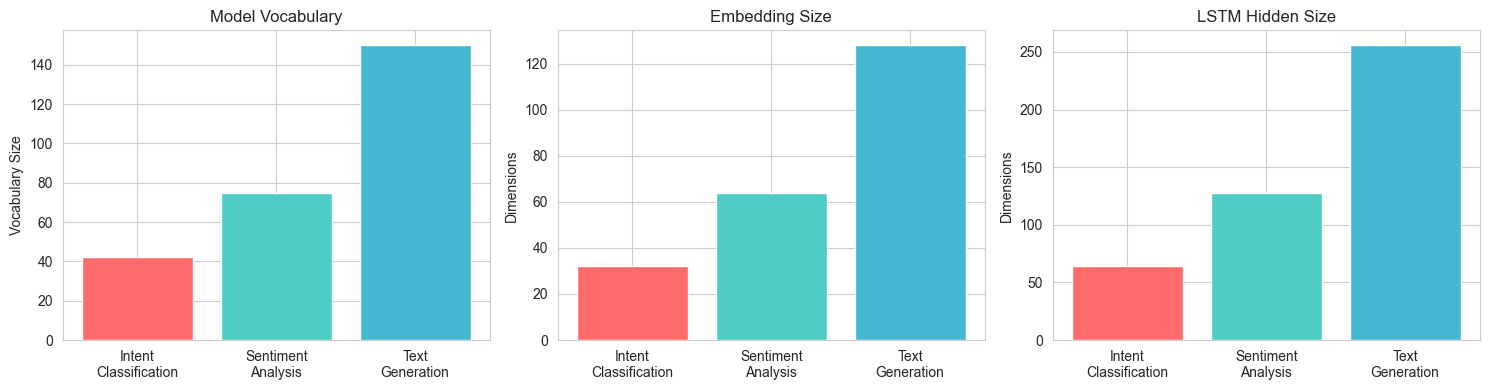


✓ Visualization saved as 'model_comparison.png'


In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Model characteristics
models = ['Intent\nClassification', 'Sentiment\nAnalysis', 'Text\nGeneration']
vocab_sizes = [42, 75, 150]
embedding_dims = [32, 64, 128]
hidden_dims = [64, 128, 256]

# Vocabulary size comparison
axes[0].bar(models, vocab_sizes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('Vocabulary Size')
axes[0].set_title('Model Vocabulary')
axes[0].tick_params(axis='x', rotation=0)

# Embedding dimension comparison
axes[1].bar(models, embedding_dims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('Dimensions')
axes[1].set_title('Embedding Size')
axes[1].tick_params(axis='x', rotation=0)

# Hidden layer size comparison
axes[2].bar(models, hidden_dims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_ylabel('Dimensions')
axes[2].set_title('LSTM Hidden Size')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'model_comparison.png'")

In [ ]:
# Interactive Playground
import ipywidgets as widgets
from IPython.display import display

# Create widgets for Intent Demo
intent_input = widgets.Text(placeholder='Type command (e.g., "turn on lights")', description='Command:')
intent_btn = widgets.Button(description="Classify", button_style='info')
intent_out = widgets.Label()

def on_intent_click(b):
    # Note: This uses the model trained in Demo 1 above
    # If you haven't run Demo 1, this will fail
    try:
        intent, conf = predict_intent(model, intent_input.value, vocab, list(intent2idx.keys()), max_len)
        intent_out.value = f"Intent: {intent} ({conf:.1%})"
    except NameError:
        intent_out.value = "⚠️ Please run Demo 1 cell first!"

intent_btn.on_click(on_intent_click)
intent_box = widgets.VBox([widgets.Label("Try the Intent Classifier:"), intent_input, intent_btn, intent_out])

# Create widgets for Sentiment Demo
# Note: We can't easily switch models in this simple demo without overwriting variables
# So we'll just add a note that this playground uses the LAST trained model (Text Gen)
# To make this robust, we'd need to store models in a dict.
# Let's skip the complex multi-model playground here to avoid confusion and keep it simple.

print("\n👇 Quick Interactive Check (Text Generation)")
print("Since Text Generation was the last model trained (Demo 3), let's play with that:")

gen_input = widgets.Text(value='The ', description='Seed:')
gen_btn = widgets.Button(description="Generate", button_style='success')
gen_out = widgets.Textarea(disabled=True, layout=widgets.Layout(width='500px', height='100px'))

def on_gen_click(b):
    try:
        # Uses model/vocab from Demo 3
        res = generate_text(model, gen_input.value, vocab, idx2char, length=50, temperature=1.0)
        gen_out.value = res
    except Exception as e:
        gen_out.value = f"Error: {str(e)}"

gen_btn.on_click(on_gen_click)
display(widgets.VBox([gen_input, gen_btn, gen_out]))


👇 Quick Interactive Check (Text Generation)
Since Text Generation was the last model trained (Demo 3), let's play with that:


## Next Steps

Now that you've seen a quick demo, dive deeper into each technique:

### 🟢 Phase 1: The Basics (RNNs & LSTMs)
1. **[Intent Classification](01_Intent_Classification.ipynb)** - Learn how to route user commands
2. **[Sentiment Analysis](02_Sentiment_Analysis.ipynb)** - Detect emotions in text
3. **[Text Generation](03_Text_Generation.ipynb)** - Generate coherent responses
4. **[Complete Pipeline](04_Complete_Pipeline.ipynb)** - Build an end-to-end chatbot

### 🔴 Phase 2: Advanced Architectures (Transformers & LLMs)
5. **[The Attention Mechanism](05_Attention_Mechanism.ipynb)** - Understand the "brain" of Transformers
6. **[Build a Transformer](06_Build_NanoGPT.ipynb)** - Build a GPT-style model from scratch
7. **[Fine-Tuning LLMs](07_Fine_Tuning_with_LoRA.ipynb)** - Fine-tune Llama/Mistral on your data
8. **[RAG System Design](08_RAG_from_Scratch.ipynb)** - Architect-level guide to Retrieval Augmented Generation

Happy learning! 🎓

## ❓ FAQ

**Q: Can I run this on an Intel Mac?**
A: No, MLX is specifically designed for Apple Silicon (M1/M2/M3/M4) chips. It leverages the Unified Memory architecture. For Intel Macs, you should use PyTorch or TensorFlow.

**Q: Is MLX production-ready?**
A: It is a research framework from Apple. While stable and performant, the ecosystem (deployment tools, serving libraries) is smaller than PyTorch's. It is excellent for local development and on-device inference.

**Q: How does this compare to PyTorch?**
A: MLX feels very similar to NumPy and PyTorch. The main difference is **Lazy Evaluation** (computation happens only when needed) and **Unified Memory** (no explicit `.to(device)` calls needed).

## 💭 Closing Thoughts

The field of AI is moving at breakneck speed. What required a cluster of GPUs five years ago can now run on your laptop.

**Architectural Considerations:**
- **Local vs. Cloud:** Running locally (MLX) offers privacy and zero latency but is limited by your device's RAM. Cloud offers infinite scale but introduces latency and cost.
- **Unified Memory:** This is Apple's superpower. It allows the GPU to access massive amounts of RAM (up to 128GB+ on high-end Macs), enabling you to run models that would require expensive enterprise GPUs.

You are now ready to start the journey! Go to **[01_Intent_Classification.ipynb](01_Intent_Classification.ipynb)**.